In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
import gc  # Garbage collector


In [2]:
def csv_chunk_reader(file_path, chunksize=100000):
    """
    Generator function to read a CSV file in chunks.
    """
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        yield chunk
        
def image_file_generator(directory, file_list):
    """
    Generator function to iterate over image files.
    """
    for file_name in file_list:
        file_path = os.path.join(directory, file_name)
        yield file_name, file_path
        
def get_image_sizes(image_dir, image_files, sample_size=None):
    """
    Get image sizes without loading all images into memory.
    """
    widths, heights = [], []
    if sample_size:
        image_files = image_files[:sample_size]
    for _, image_path in tqdm(image_file_generator(image_dir, image_files), total=len(image_files)):
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
    return widths, heights


In [3]:
def analyze_dataset_metadata(metadata_df, dataset_name):
    """
    Analyze dataset metadata, labels, demographics, and image dimensions using metadata.
    """
    print(f"\n--- Analyzing {dataset_name} Dataset ---")
    num_images = metadata_df.shape[0]
    print(f"Number of images: {num_images}")
    
    # Unique Patients
    if 'Patient ID' in metadata_df.columns:
        num_patients = metadata_df['Patient ID'].nunique()
        print(f"Number of unique patients: {num_patients}")
    else:
        num_patients = 'N/A'
        print("Patient ID information not available.")
    
    # Labels and Annotations
    if 'Labels List' not in metadata_df.columns:
        if 'Finding Labels' in metadata_df.columns:
            metadata_df['Labels List'] = metadata_df['Finding Labels'].str.split('|')
        elif 'Labels' in metadata_df.columns:
            metadata_df['Labels List'] = metadata_df['Labels'].str.split('|')
        else:
            label_cols = [col for col in metadata_df.columns if col not in ['Path', 'Sex', 'Age', 'View Position', 'Patient ID', 'Study']]
            metadata_df['Labels List'] = metadata_df[label_cols].apply(lambda x: x.index[x==1].tolist(), axis=1)
    
    # Explode labels
    all_labels = metadata_df.explode('Labels List')['Labels List']
    unique_labels = all_labels.dropna().unique()
    print(f"Unique labels: {unique_labels}")
    
    # Count label occurrences
    from collections import Counter
    label_counts = Counter(all_labels.dropna())
    label_counts_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['Count'])
    label_counts_df = label_counts_df.sort_values('Count', ascending=False)
    
    # Display label counts
    print("\nLabel counts:")
    display(label_counts_df)
    
    # Plot class distribution
    plt.figure(figsize=(12,6))
    sns.barplot(x=label_counts_df.index, y='Count', data=label_counts_df)
    plt.title(f'{dataset_name} Class Distribution')
    plt.ylabel('Number of Images')
    plt.xlabel('Disease Labels')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Demographics Analysis
    # Adjusted to use the correct 'Patient Age' column and clean data
    print("\n--- Age Analysis ---")
    if 'Patient Age' in metadata_df.columns:
        # Convert 'Patient Age' to numeric
        metadata_df['Patient Age'] = pd.to_numeric(metadata_df['Patient Age'], errors='coerce')
        # Define realistic age range
        min_age = 0
        max_age = 100
        # Filter out unrealistic ages
        valid_age_mask = (metadata_df['Patient Age'] >= min_age) & (metadata_df['Patient Age'] <= max_age)
        valid_age_data = metadata_df.loc[valid_age_mask, 'Patient Age']
        # Report number of invalid age entries
        num_invalid_ages = metadata_df.shape[0] - valid_age_data.shape[0]
        print(f"Number of entries with invalid ages removed: {num_invalid_ages}")
        # Plot the cleaned age distribution
        plt.figure(figsize=(8,5))
        sns.histplot(valid_age_data, bins=30, kde=False)
        plt.title(f'{dataset_name} Age Distribution')
        plt.xlabel('Age (years)')
        plt.ylabel('Number of Patients')
        plt.show()
    else:
        print("Age information not available.")
    
    # Gender Analysis
    if 'Patient Gender' in metadata_df.columns:
        gender_counts = metadata_df['Patient Gender'].value_counts()
    elif 'Sex' in metadata_df.columns:
        gender_counts = metadata_df['Sex'].value_counts()
    else:
        gender_counts = None
    
    if gender_counts is not None:
        plt.figure(figsize=(6,6))
        plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title(f'{dataset_name} Gender Distribution')
        plt.ylabel('')
        plt.show()
    else:
        print("Gender information not available.")
    
    # Data Quality Assessment - Image Dimensions from Metadata
    print(f"\nAnalyzing image dimensions for {dataset_name} from metadata...")
    if 'OriginalImageWidth' in metadata_df.columns and 'OriginalImageHeight' in metadata_df.columns:
        # Convert columns to numeric
        metadata_df['OriginalImageWidth'] = pd.to_numeric(metadata_df['OriginalImageWidth'], errors='coerce')
        metadata_df['OriginalImageHeight'] = pd.to_numeric(metadata_df['OriginalImageHeight'], errors='coerce')
        # Remove rows with missing values
        image_sizes_df = metadata_df[['OriginalImageWidth', 'OriginalImageHeight']].dropna()
        # Display basic statistics
        print("Image size statistics:")
        display(image_sizes_df.describe())
        # Visualize image resolution distribution
        plt.figure(figsize=(8,5))
        sns.histplot(image_sizes_df['OriginalImageWidth'], bins=20, color='blue', label='Width', kde=False)
        sns.histplot(image_sizes_df['OriginalImageHeight'], bins=20, color='orange', label='Height', kde=False)
        plt.title(f'{dataset_name} Image Resolution Distribution')
        plt.xlabel('Pixels')
        plt.ylabel('Number of Images')
        plt.legend()
        plt.show()
        # Get mean width and height
        image_width_mean = image_sizes_df['OriginalImageWidth'].mean()
        image_height_mean = image_sizes_df['OriginalImageHeight'].mean()
    else:
        print("Image dimensions not available in metadata.")
        image_width_mean = None
        image_height_mean = None
    
    # Identify Long-Tailed Distributions
    label_counts_df['Cumulative Count'] = label_counts_df['Count'].cumsum()
    label_counts_df['Cumulative Percentage'] = 100 * label_counts_df['Cumulative Count'] / label_counts_df['Count'].sum()
    
    # Plot Cumulative Distribution
    plt.figure(figsize=(8,5))
    sns.lineplot(data=label_counts_df, x=range(len(label_counts_df)), y='Cumulative Percentage')
    plt.title(f'Cumulative Distribution of {dataset_name} Labels')
    plt.xlabel('Number of Labels')
    plt.ylabel('Cumulative Percentage')
    plt.show()
    
    # Return key metrics for comparative analysis
    return {
        'Dataset': dataset_name,
        'Number of Images': num_images,
        'Number of Patients': num_patients,
        'Number of Classes': len(unique_labels),
        'Labels': unique_labels,
        'Label Counts': label_counts_df['Count'].to_dict(),
        'Image Width Mean': image_width_mean,
        'Image Height Mean': image_height_mean
    }


In [4]:
# Update these paths to where your datasets are stored

# NIH ChestX-ray14
nih_metadata_path = './data/NIH/Data_Entry_2017.csv'
nih_images_dir = './data/NIH'  # Update to your images directory

# CheXpert
chexpert_metadata_path = 'path_to_CheXpert_data/train.csv'
chexpert_images_dir = 'path_to_CheXpert_data'  # Images are in subdirectories

# MIMIC-CXR
mimic_metadata_path = 'path_to_MIMIC_data/mimic-cxr-2.0.0-metadata.csv'
mimic_labels_path = 'path_to_MIMIC_data/labels.csv'  # Assuming labels are preprocessed
mimic_images_dir = 'path_to_MIMIC_images/files'  # Update to your images directory

# Parameters
csv_chunksize = 50000  # Adjust based on your system's memory
image_sample_size = 1000  # Number of images to sample for analysis


In [5]:
# Initialize an empty DataFrame to store metadata
nih_metadata = pd.DataFrame()
# Use the generator to read the CSV file in chunks
for chunk in csv_chunk_reader(nih_metadata_path, chunksize=csv_chunksize):
    nih_metadata = pd.concat([nih_metadata, chunk], ignore_index=True)

print(f"NIH Metadata Loaded: {nih_metadata.shape[0]} records")


/home/tokereines/repositories/PREP
NIH Metadata Loaded: 112120 records


In [ ]:
head data/NIH/Data_Entry_2017.csv


--- Analyzing NIH ChestX-ray14 Dataset ---
Number of images: 112120
Number of unique patients: 30805
Unique labels: ['Cardiomegaly' 'Emphysema' 'Effusion' 'No Finding' 'Hernia'
 'Infiltration' 'Mass' 'Nodule' 'Atelectasis' 'Pneumothorax'
 'Pleural_Thickening' 'Pneumonia' 'Fibrosis' 'Edema' 'Consolidation']

Label counts:


,Count
No Finding,60361
Infiltration,19894
Effusion,13317
Atelectasis,11559
Nodule,6331
Mass,5782
Pneumothorax,5302
Consolidation,4667
Pleural_Thickening,3385
Cardiomegaly,2776


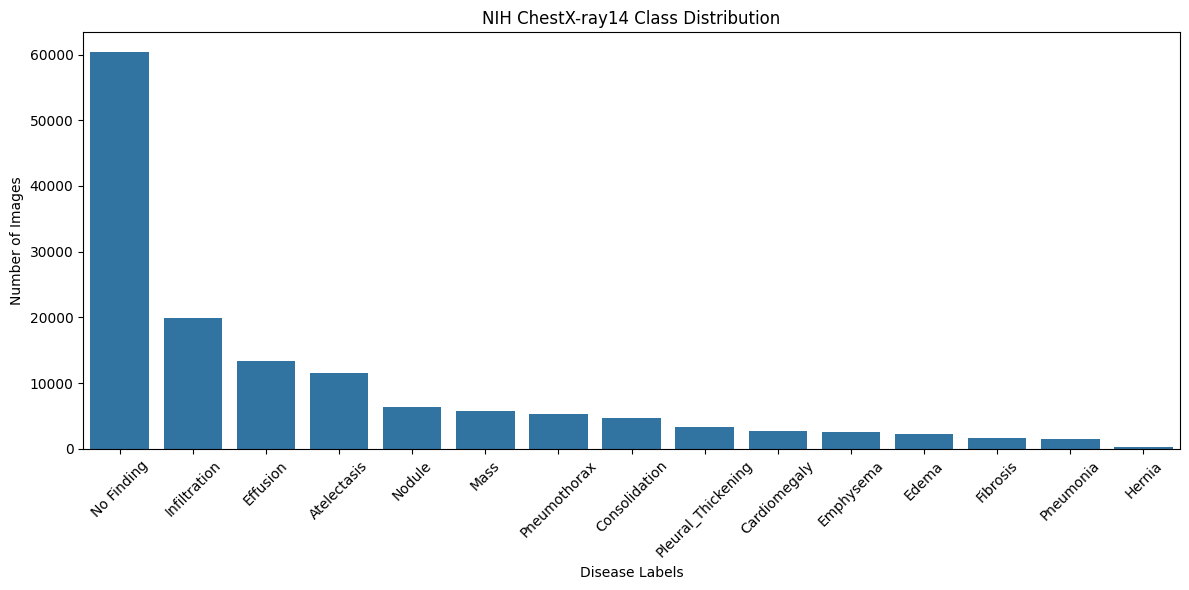

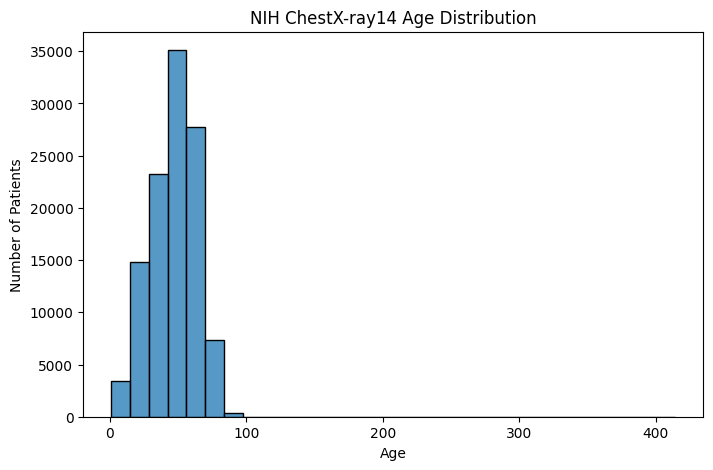

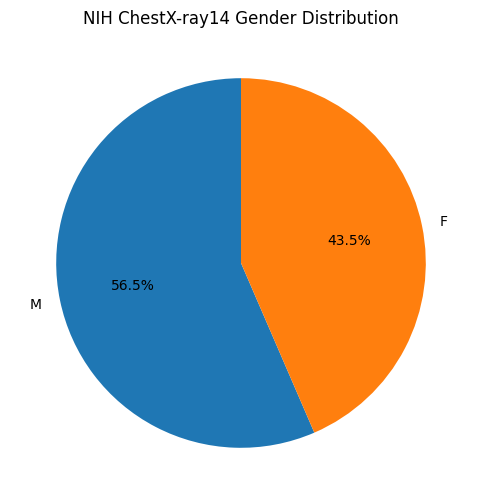


Analyzing image resolutions for NIH ChestX-ray14...


100%|██████████| 1000/1000 [00:00<00:00, 11549.37it/s]

Error processing ./data/NIH/00000001_000.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/NIH/00000001_000.png'
Error processing ./data/NIH/00000001_001.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/NIH/00000001_001.png'
Error processing ./data/NIH/00000001_002.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/NIH/00000001_002.png'
Error processing ./data/NIH/00000002_000.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/NIH/00000002_000.png'
Error processing ./data/NIH/00000003_000.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/NIH/00000003_000.png'
Error processing ./data/NIH/00000003_001.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/NIH/00000003_001.png'
Error processing ./data/NIH/00000003_002.png: [Errno 2] No such file or directory: '/home/tokereines/repositories/PREP/data/

,Width,Height
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


/tmp/ipykernel_754976/4014207325.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


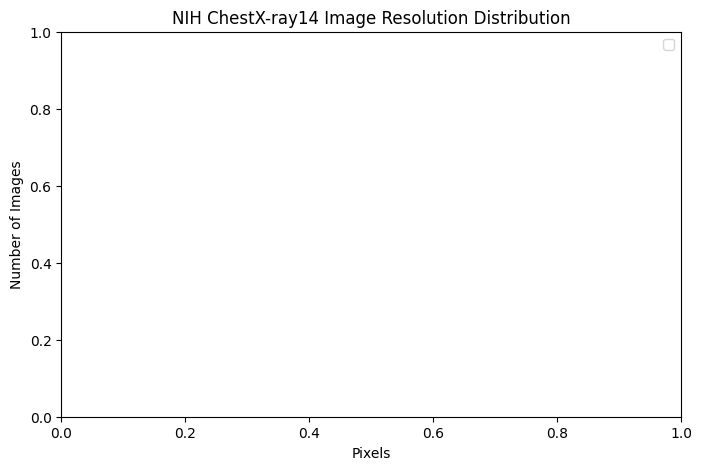

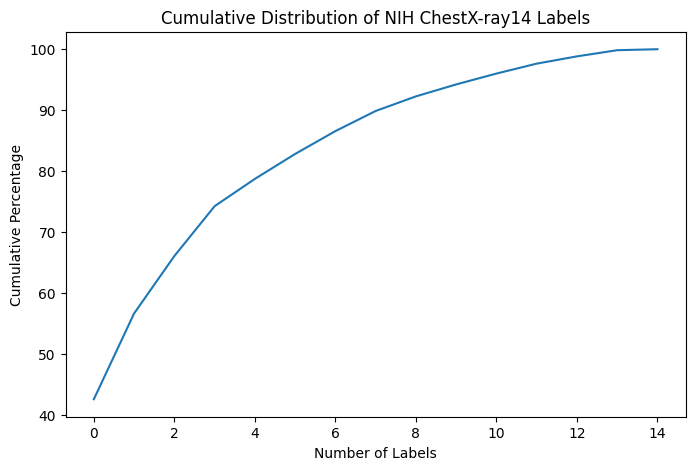

In [7]:
nih_metrics = analyze_dataset_metadata(nih_metadata, nih_images_dir, 'NIH ChestX-ray14', image_sample_size=image_sample_size)